In [ ]:
!pip install wfdb
!pip install import-ipynb
!pip install imbalanced-learn
from google.colab import drive
ROOT = '/content/drive'
drive.mount('/content/drive')

In [2]:
%cd "drive/My Drive/Colab Notebooks/Python/MLP_arrhythmia_database/Resultados_MLP_Arritmia"

/content/drive/My Drive/Colab Notebooks/Python/MLP_arrhythmia_database/Resultados_MLP_Arritmia


In [3]:
import wfdb
from wfdb import processing
import math
import pywt
import pandas as pd
import numpy as np
from numpy import *
from numpy import load
import scipy.io as sio
import numpy.matlib 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
from os import listdir
%matplotlib inline

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
import json

import import_ipynb
from SeparacaoAAMI import *

import random   
random.seed(30) 

ind_plt_recall = 0

importing Jupyter notebook from SeparacaoAAMI.ipynb


In [4]:
fs = 360
pasta = 'mit-bih-arrhythmia-database-1.0.0/'
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']
DS2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']
N = ['N', 'L', 'R', 'e', 'j']
S = ['A', 'a', 'J', 'S']
V = ['V', 'E']
F = ['F']
Q = ['/', 'f', 'Q']
nonbeat = ['[', ']', '!', 'x', '|', '~', '+', '"']
with open('simbolos_versaofinal.json', 'r') as json_file:
    simbolos = json.load(json_file)

In [5]:
#@title
# lim = 2400
# delineation_arq = '100'
# lead = 0
# pos_vec = 1
# e = 1e10

# s, sim_importaArquivo, a = importaArquivoChazal(pasta, delineation_arq) 
# QRSon, QRSoff, T, P, R, sym = waveDelineation(pasta, delineation_arq, lead, simbolos)
# print('\n', QRSon[QRSon < lim], '\n', QRSoff[QRSoff < lim], '\n', T[T < lim], '\n', P[P < lim], '\n', R[R < lim])

# plt.figure(figsize=[15,5])
# plt.plot(s.p_signal[0:lim,lead])
# sig = s.p_signal[0:lim,lead]
# #sig[list(delin[delin < lim].astype(int))
# # plt.fill_between(delin[delin < lim], 0, 1])

# plt.plot(QRSon[QRSon < lim], sig[list(QRSon[QRSon < lim].astype(int))], 'ro')
# plt.plot(QRSoff[QRSoff < lim], sig[list(QRSoff[QRSoff < lim].astype(int))], 'go')

# plt.figure(figsize=[15,5])
# plt.plot(s.p_signal[0:lim,lead])
# #sig[list(delin[delin < lim].astype(int))
# # plt.fill_between(delin[delin < lim], 0, 1])

# plt.plot(T[T < lim], sig[list(T[T < lim].astype(int))], 'ko')
# plt.plot(P[P < lim], sig[list(P[P < lim].astype(int))], 'mo')
# # plt.plot(R[R < lim], sig[list(R[R < lim].astype(int))], 'yo')
# plt.plot(a[a < lim], sig[list(a[a < lim].astype(int))], 'yo')
# plt.show()

# #################################################
# sig = s.p_signal[:,0]

# # plt.figure(figsize=[15,5])
# # plt.plot(s.p_signal[:,0])
# # plt.plot(QRSon[QRSon < sig.shape[0]].astype(int), sig[list(QRSon[QRSon < sig.shape[0]].astype(int))], 'ro')
# # plt.plot(QRSoff[QRSoff < sig.shape[0]].astype(int), sig[list(QRSoff[QRSoff < sig.shape[0]].astype(int))], 'go')
# # plt.show()
# #################################################

# if (((QRSon[pos_vec] < e) and (QRSoff[pos_vec] < e)) and (T[pos_vec] < e) and (sym[pos_vec] != None)):
#     f_qrs_int, xnovo_qrs, f_t_int, xnovo_t = pontos(sig, QRSon, QRSoff, T, R, pos_vec)
#     if isnan(P[pos_vec]) or isnan(P[pos_vec + 1]):
#         x_qrst = np.hstack((np.arange(QRSon[pos_vec],QRSoff[pos_vec]), np.arange(QRSoff[pos_vec],T[pos_vec])))
#         xnovo_qrst = np.hstack((xnovo_qrs, xnovo_t))
#         y_qrst = np.hstack((sig[QRSon[pos_vec].astype(int):QRSoff[pos_vec].astype(int)], sig[QRSoff[pos_vec].astype(int):T[pos_vec].astype(int)]))
#         plt.figure(figsize=[15,5])
#         plt.plot(x_qrst, y_qrst)
#         plt.plot(xnovo_qrst, np.hstack((f_qrs_int, f_t_int)), 'ro')
#     else:
#         x_qrst = np.arange(P[pos_vec],P[pos_vec + 1])
#         xnovo_qrst = np.hstack((xnovo_qrs, xnovo_t))
#         plt.figure(figsize=[15,5])
#         plt.plot(x_qrst, sig[P[pos_vec].astype(int):P[pos_vec + 1].astype(int)])
#         plt.plot(xnovo_qrst, np.hstack((f_qrs_int, f_t_int)), 'ro')

# print(sym)

In [6]:
periodo = 320
X_train, Y_train_int, Sym_train = datasetAAMIChazal1(pasta, DS1, periodo, fs, simbolos)
X_test, Y_test_int, Sym_test =    datasetAAMIChazal1(pasta, DS2, periodo, fs, simbolos)

In [7]:
print(X_train.shape)
print(X_test.shape)

(12224, 320)
(12037, 320)


In [8]:
from sklearn.utils import class_weight

Y_train_flat = Y_train_int.flatten()
pesos = class_weight.compute_class_weight('balanced', np.unique(Y_train_flat), Y_train_flat)
print(pesos)
pesos = pesos*10
pesos = list(map(math.ceil,pesos))
pesos = {i: pesos[i] for i in range(np.size(pesos))}

pesos

[2.86477619e-01 3.23814570e+00 9.63278172e-01 6.17373737e+00
 2.44480000e+03]


{0: 3, 1: 33, 2: 10, 3: 62, 4: 24448}

In [9]:
#@title
def plotECG(morf, X_train, id1, id2, id3, id4, id5):
  if(morf == True):
      carac = ['Pré-RR', 'Pós-RR', 'Med-RR Total', 'Med-RR local', 'duração do QRS', 'duração da onda T', 'presença da onda P']
      plt.figure(figsize=[15,5])
      plt.xticks(np.arange(0,7,1), carac)
      plt.plot(carac, X_train[id1, 0:7], 'b')
      plt.plot(carac, X_train[id2, 0:7], 'r')
      plt.plot(carac, X_train[id3, 0:7], 'g')
      plt.plot(carac, X_train[id4, 0:7], 'k')
      plt.plot(carac, X_train[id5, 0:7], 'm')
      plt.title('Caracteristicas')
      plt.legend(['N', 'S', 'V', 'F', 'Q'])
      plt.ylabel('Amostras')
      plt.show()
      plt.plot(X_train[id1, 7:], 'b')
      plt.title('Interpolação de ECG da classe N')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id2, 7:], 'r')
      plt.title('Interpolação de ECG da classe S')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id3, 7:], 'g')
      plt.title('Interpolação de ECG da classe V')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id4, 7:], 'k')
      plt.title('Interpolação de ECG da classe F')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id5, 7:], 'm')
      plt.title('Interpolação de ECG da classe Q')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
  else:
      plt.plot(X_train[id1,:], 'b')
      plt.title('ECG da classe N')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id2,:], 'r')
      plt.title('ECG da classe S')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id3,:], 'g')
      plt.title('ECG da classe V')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id4,:], 'k')
      plt.title('ECG da classe F')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()
      plt.plot(X_train[id5,:], 'm')
      plt.title('ECG da classe Q')
      plt.ylabel('Amplitude (mV)')
      plt.xlabel('Amostras')
      plt.show()

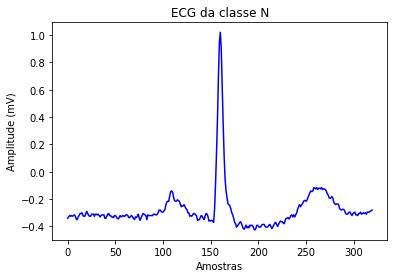

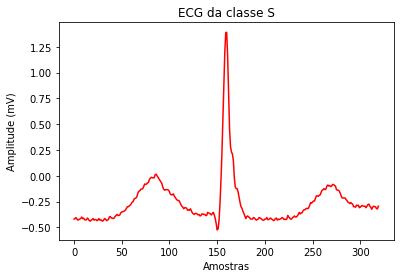

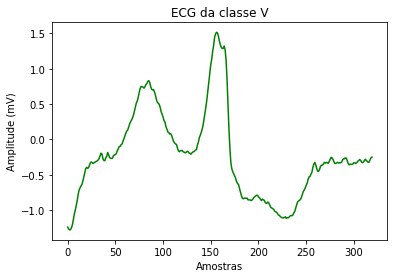

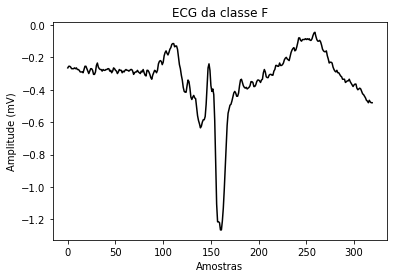

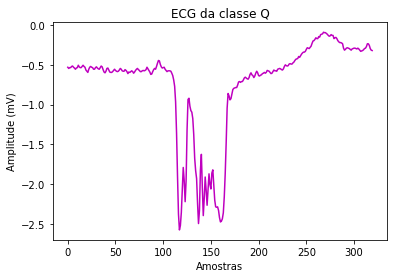

In [10]:
id1 = np.where(Y_train_int == 0)[0][0]
id2 = np.where(Y_train_int == 1)[0][0]
id3 = np.where(Y_train_int == 2)[0][0]
id4 = np.where(Y_train_int == 3)[0][0]
id5 = np.where(Y_train_int == 4)[0][0]
plotECG(False, X_train, id1, id2, id3, id4, id5)

In [11]:
numclass = 5

#one hot encoding
Y_train = np.eye(numclass)[Y_train_int.astype('int32')]
Y_test = np.eye(numclass)[Y_test_int.astype('int32')]
Y_train = Y_train.T.reshape(numclass, X_train.shape[0])
Y_test = Y_test.T.reshape(numclass, X_test.shape[0])

Y_train = Y_train.T
Y_test = Y_test.T

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12224, 320)
(12037, 320)
(12224, 5)
(12037, 5)


Construindo a MLP

In [12]:
split = X_test.shape[0]/(X_test.shape[0] + X_train.shape[0])
print(split)
all_X = np.concatenate((X_train, X_test), axis = 0)
all_label = np.concatenate((Y_train, Y_test), axis = 0)
print(all_X.shape, all_label.shape)

0.49614607806768063
(24261, 320) (24261, 5)


In [13]:
#@title
from sklearn.utils import shuffle #bias
###################bias#######################
# all_X, all_label = shuffle(all_X, all_label)
# all_label_int = all_label.flatten()

# X_train = all_X[:X_train.shape[0], :]
# Y_train = all_label[:Y_train.shape[0]]
# X_test = all_X[X_train.shape[0]:, :]
# Y_test = all_label[Y_train.shape[0]:]
##############################################

In [14]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12224, 320)
(12037, 320)
(12224, 5)
(12037, 5)


In [15]:
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (all_X.shape[1],)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.15))

model.add(layers.Dense(numclass, activation = 'softmax'))

adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy', tf.keras.metrics.Recall()])

history = model.fit(all_X, all_label, batch_size=2048, shuffle=True, epochs=1000, validation_split=split, verbose = False, class_weight = pesos) #validationsplit pega os ultimos dados de all_X antes do shuffle

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                20544     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 25,029
Trainable params: 25,029
Non-trainable params: 0
_________________________________________________________________


In [17]:
Y_train_preds = model.predict(X_train, verbose = 0)
Y_test_preds = model.predict(X_test, verbose = 0)

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print('-------------------------Treino------------------------')

Y_hat_train = np.argmax(Y_train_preds, axis=1)
Y_real_train = np.argmax(Y_train, axis=1)
print(confusion_matrix(Y_real_train, Y_hat_train))
print(classification_report(Y_real_train, Y_hat_train, digits = 4))

print('-------------------------Teste------------------------')

Y_hat_test = np.argmax(Y_test_preds, axis=1)
Y_real_test = np.argmax(Y_test, axis=1)
M = confusion_matrix(Y_real_test, Y_hat_test)
print(confusion_matrix(Y_real_test, Y_hat_test))
print(classification_report(Y_real_test, Y_hat_test, digits = 4))


-------------------------Treino------------------------
[[8474   43    7    9    1]
 [   0  755    0    0    0]
 [   1    2 2526    9    0]
 [   0    0    0  396    0]
 [   0    0    0    0    1]]
              precision    recall  f1-score   support

           0     0.9999    0.9930    0.9964      8534
           1     0.9437    1.0000    0.9711       755
           2     0.9972    0.9953    0.9963      2538
           3     0.9565    1.0000    0.9778       396
           4     0.5000    1.0000    0.6667         1

    accuracy                         0.9941     12224
   macro avg     0.8795    0.9976    0.9216     12224
weighted avg     0.9944    0.9941    0.9942     12224

-------------------------Teste------------------------
[[6063  889  662  689    0]
 [ 955  314   42    8    0]
 [  94   37 1809   94    0]
 [ 150    0  215   11    0]
 [   1    0    3    1    0]]
              precision    recall  f1-score   support

           0     0.8348    0.7302    0.7790      8303
         

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
TN = M[0,0]
TPv = M[2,2]
TPs = M[1,1]
TPf = M[3,3]
TPq = M[4,4]
Spec = 100*TN/np.sum(M[0,:])
Sensi_F = 100*TPf/np.sum(M[3,:])
Sensi_Q = 100*TPq/np.sum(M[4,:])
print('------Normal------')
print('\n', 'Especificidade:', Spec, '\n')

TNs = M[0,0] + np.sum(M[0, 2:]) + np.sum(M[2:, 0]) + np.sum(M[2:, 2:])
FNs = np.sum(M[1, 0]) + np.sum(M[1, 2:])
TPs = M[1,1]
FPs = M[0, 1] + np.sum(M[2:4, 1])
Sensi_SVEB = 100*TPs/(TPs + FNs)
Spec_SVEB = 100*TNs/(TNs + FPs)
Preci_SVEB = 100*TPs/(TPs + FPs)
FPR_SVEB = 100*FPs/(TNs + FPs)
Acc_SVEB = 100*(TPs + TNs)/(TPs + TNs + FPs + FNs)
HM_SVEB = 2*Sensi_SVEB*Spec_SVEB/(Sensi_SVEB + Spec_SVEB)
print('------SVEB------')
print('\n', 'Sensibilidade:', Sensi_SVEB, '\n', 'Especificidade:', Spec_SVEB, '\n','Precisão:', Preci_SVEB, '\n', 'Taxa de Falsos Positivos:', FPR_SVEB, '\n', 'Acurácia:', Acc_SVEB, '\n', 'HM:', HM_SVEB, '\n')

TNv = np.sum(M[0:2, 0:2]) + np.sum(M[3:, 0:2]) + np.sum(M[0:2, 3:]) + np.sum(M[3:, 3:])
FNv = np.sum(M[2, 0:2]) + np.sum(M[2, 3:])
TPv = M[2,2]
FPv = M[0, 2] + M[1, 2]
Sensi_VEB = 100*TPv/(TPv + FNv)
Spec_VEB = 100*TNv/(TNv + FPv)
Preci_VEB = 100*TPv/(TPv + FPv)
FPR_VEB = 100*FPv/(TNv + FPv)
Acc_VEB = 100*(TPv + TNv)/(TPv + TNv + FPv + FNv)
HM_VEB = 2*Sensi_VEB*Spec_VEB/(Sensi_VEB + Spec_VEB)
print('------VEB------')
print('\n', 'Sensibilidade:', Sensi_VEB, '\n', 'Especificidade:', Spec_VEB, '\n', 'Precisão:', Preci_VEB, '\n', 'Taxa de Falsos Positivos:', FPR_VEB, '\n', 'Acurácia:', Acc_VEB, '\n', 'HM:', HM_VEB, '\n')

print('------F------')
print('\n', 'Sensibilidade:', Sensi_F, '\n')


print('------Q------')
print('\n', 'Sensibilidade:', Sensi_Q, '\n')

------Normal------

 Especificidade: 73.02179934963266 

------SVEB------

 Sensibilidade: 23.805913570887036 
 Especificidade: 91.36032841948125 
 Precisão: 25.322580645161292 
 Taxa de Falsos Positivos: 8.639671580518753 
 Acurácia: 83.95779679322091 
 HM: 37.77002782367285 

------VEB------

 Sensibilidade: 88.93805309734513 
 Especificidade: 92.80531425651508 
 Precisão: 71.98567449263828 
 Taxa de Falsos Positivos: 7.194685743484926 
 Acurácia: 92.13977493865809 
 HM: 90.83053854714909 

------F------

 Sensibilidade: 2.925531914893617 

------Q------

 Sensibilidade: 0.0 



In [20]:
#@title
# print(history.history.keys())
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()

# if (ind_plt_recall == 0):
#     plt.plot(history.history['recall'])
#     plt.plot(history.history['val_recall'])
# else:
#     plt.plot(history.history[str('recall_' + str(ind_plt_recall))])
#     plt.plot(history.history[str('val_recall_' + str(ind_plt_recall))])

# plt.title('Model recall')
# plt.ylabel('Recall')
# plt.xlabel('Epoch')
# plt.show()

# ind_plt_recall = ind_plt_recall + 1